# Guided Project #16: Predicting House Sale Prices

In this guided project, we will practice what we've learned in this course by exploring ways to improve the models we built.

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

The solutions notebook for this guided project can be found [here](https://github.com/dataquestio/solutions/blob/master/Mission240Solutions.ipynb).

In [420]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [288]:
houses = pd.read_csv('AmesHousing.tsv', delimiter='\t')
houses.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Our pipeline will consist of the following functions:
- transform_features()
- select_features()
- train_and_test()

Let's start with creating dummy versions of those functions

In [289]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [290]:
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]

    selected_features = select_features(train)
    features = selected_features.select_dtypes(['float','int']).drop(columns=['SalePrice'])
    target = selected_features['SalePrice']
    
    lr = LinearRegression()
    lr.fit(features, target)
    
    prediction = lr.predict(test[features.columns])
    mse = mean_squared_error(prediction, test['SalePrice'])
    
    return mse**(1/2)

In [291]:
print(train_and_test(houses))

57088.25161263909


Let's now work on transform_features() function. 

In [344]:
def transform_features(df):
    tf = df.copy() #Transformed df
    
    # First, let's have it dropping the features with more than 25% of missing values
    missing_gt5_mask = tf.isnull().sum() > 0.05*len(tf)
    features = tf.columns[~missing_gt5_mask]
    tf = tf[features]
    
    # Now let's figure out features with less than 5% missing values
    less_5_mask = (tf.isnull().sum() <= 0.05 * len(tf)) & (tf.isnull().sum() > 0)
    less_5_features = tf.columns[less_5_mask]
    
    # for numeric of those let's replace them with most frequent values
    less_5_numeric = tf[less_5_features].select_dtypes(include=['int','float']).columns

    filler = {}
    for col in less_5_numeric:
        most_frequent = tf[col].value_counts().index[0]
        filler[col] = most_frequent
    tf.fillna(filler, inplace=True)
    
    # for text columns let's remove columns with any number of missing values
    missing_mask = tf.isnull().sum() > 0
    missing_columns = missing_mask[missing_mask].index
    missing_text_columns = tf[missing_columns].select_dtypes(include=['object']).columns
    tf.drop(columns=missing_text_columns, inplace=True)
    
    # Constructing two new features:
    tf['Age Sold'] = tf['Yr Sold'] - tf['Year Built']
    tf['Years Since Remod'] = tf['Yr Sold'] - tf['Year Remod/Add']
    bad_values_index = tf[(tf['Age Sold']<0) | (tf['Years Since Remod']<0)].index
    tf.drop(bad_values_index, inplace=True)
    
    # Dropping not usable columns
    tf.drop(columns=['PID','Order','Mo Sold','Sale Condition','Sale Type',
                     'Year Built','Year Remod/Add','Yr Sold'],
            inplace=True)
    
    return tf

Let's work on feature selection now

In [381]:
df = transform_features(houses).select_dtypes(include=['int','float'])

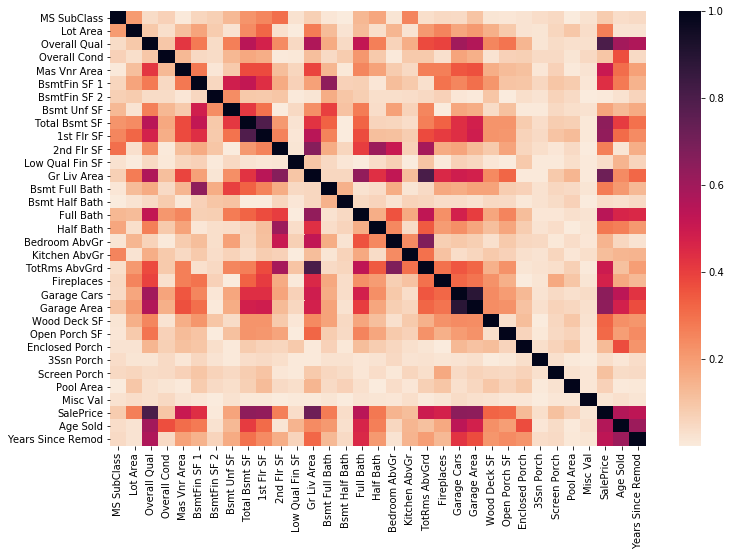

In [382]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))   
sns.heatmap(df.corr().abs(), cmap=sns.cm.rocket_r, ax=ax)

In [366]:
corr = df.corr().abs()['SalePrice'].sort_values(ascending=False).drop('SalePrice')
# High correlation features:
threshold = 0.3
corr[corr>threshold]

Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648427
Total Bsmt SF        0.643782
Garage Area          0.641690
1st Flr SF           0.635185
Age Sold             0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.513121
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439051
Wood Deck SF         0.328183
Open Porch SF        0.316262
Name: SalePrice, dtype: float64

Looking at the heatmap, we can see that TotRms AvbGrd is highly correlated with Gr Liv Area, Garage Cars is highly correlated with Garage Area let's drop TotRms AvbGrd and Garage Cars, as areas have very similar meaning while being continuous variables.

Let's review categorical features

In [296]:
df = transform_features(houses).select_dtypes(include=['object'])

In [297]:
n = len(df)
var_features = [] # High variance categorical features
for col in df.columns:
    if df[col].value_counts()[0]/n < 0.95:
        var_features.append(col)
var_features

['MS Zoning',
 'Lot Shape',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Heating QC',
 'Central Air',
 'Kitchen Qual',
 'Functional',
 'Paved Drive']

In [298]:
for col in var_features:
    print(col, len(df[col].unique()))

MS Zoning 7
Lot Shape 4
Land Contour 4
Lot Config 5
Neighborhood 28
Condition 1 9
Bldg Type 5
House Style 8
Roof Style 6
Exterior 1st 16
Exterior 2nd 17
Exter Qual 4
Exter Cond 5
Foundation 6
Heating QC 5
Central Air 2
Kitchen Qual 5
Functional 8
Paved Drive 3


Numeric categorical features

In [299]:
df = transform_features(houses).select_dtypes(include=['float','int'])
df.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Age Sold,Years Since Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,0,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,212,34,0,0,0,0,0,189900,13,12


It seems only MS SubClass is a numeric feature that should be traeted as categorical

In [300]:
df['MS SubClass'].value_counts()

20     1078
60      573
50      287
120     192
30      139
160     129
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MS SubClass, dtype: int64

Let's redefine select_features() function now

In [400]:
def select_features(df):
    corr = df.corr().abs()['SalePrice'].sort_values(ascending=False)

    # High correlation numeric features:
    threshold = 0.3
    high_corr_features = corr[corr>threshold].index
    
    # Selected features
    sf = df[high_corr_features].copy()
    
    n = len(df)
    
    # High variance categorical features (most frequent value is met less than 95% times) 
    # with less than 10 unique values
    cat_features = df.select_dtypes(include=['object']).columns
    for col in cat_features:
        if cf[col].value_counts().iloc[0]/n < 0.95 and len(cf[col].value_counts()) <= 10:
            col_cats = pd.get_dummies(cf[col])
            sf = pd.concat([sf, col_cats], axis = 1)
                                      
    return sf

Checking against our pipeline

In [401]:
tf = transform_features(houses)
sf = select_features(tf)
train_and_test(sf)

36607.88007627672

Now lets update train_and_test() function to receive k parameter that controls the type of validation

In [346]:
d = pd.get_dummies(tf['MS SubClass'])

In [353]:
cf = tf.copy()
cf['MS SubClass'] = cf['MS SubClass'].astype(str)

In [354]:
cf.head()

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Age Sold,Years Since Remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,210,62,0,0,0,0,0,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,140,0,0,0,120,0,0,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,0,0,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,212,34,0,0,0,0,0,189900,13,12


In [424]:
def train_and_test(df, k=0):
    
    features = df.select_dtypes(['float','int']).drop(columns=['SalePrice']).columns
    target = 'SalePrice'

    lr = LinearRegression()
        
    if k==0: 
        # holdout validation
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train[target])

        prediction = lr.predict(test[features])
        mse = mean_squared_error(prediction, test[target])

        return mse**(1/2)
    
    elif k==1:
        # simple cross validation
        df = df.sample(frac=1, random_state=1)
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        target = 'SalePrice'
        
        lr.fit(fold_one.drop(columns=[target]), fold_one[target])
        pred1 = lr.predict(fold_two.drop(columns=[target]))
        mse1 = mean_squared_error(pred1, fold_two[target])
        rmse1 = np.sqrt(mse1)
        
        lr.fit(fold_two.drop(columns=[target]), fold_two[target])
        pred2 = lr.predict(fold_one.drop(columns=[target]))
        mse2 = mean_squared_error(pred2, fold_one[target])
        rmse2 = np.sqrt(mse2)
        
        return np.mean([rmse1, rmse2])
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        return np.mean(rmse_values)
        

In [428]:
train_and_test(sf, k=4)

[37660.71646406602, 30313.036317883852, 34099.04978882704, 30824.91164038158]


33224.42855278963

That's it for the guided steps. Here's some potenial next steps that you can take:

Continue iteration on feature engineering:
- Reserach some other approaches to feature engineering online around housing data.
- Visit the [Kaggle kernels page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels) for this dataset to see approaches others took.

Improve your feature selection:
- Research ways of doing feature selection better with categorical columns (something we didn't cover in this particular course).

Curious to see what other students have done on this project? Head over to our [Community](https://community.dataquest.io/tags/c/social/share/49/240) to check them out. While you are there, please remember to show some love and give your own feedback!